In [1]:
import pandas as pd
import numpy as np
import datetime
from dask import delayed,compute
from numpy import loadtxt

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor
 
from sklearn.cluster import DBSCAN
from sklearn.decomposition import KernelPCA
import hdbscan
from sklearn.ensemble import RandomForestClassifier
import joblib
from joblib import parallel_backend
import itertools
import scipy.stats as st
from sklearn.model_selection import ParameterGrid
from coranking.metrics import trustworthiness as tw
from coranking.metrics import continuity as ct
from coranking.metrics import LCMC as lcmc
import ast
from sklearn.metrics import pairwise_distances_chunked
import dask.array as da
import re
import lhsmdu
from sklearn.neighbors import KNeighborsRegressor
import shap
dd

In [2]:
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import squareform
import scipy.stats as ss
from sklearn.metrics import mutual_info_score
import copy
import dask
from dask.distributed import wait
from sklearn_extra.cluster import KMedoids
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Data Loading and Cleaning


In [29]:
electric = pd.read_csv('ele.csv')
electric.head(5)

,Unnamed: 0,mels_S,lig_S,lig_N,mels_N,hvac_N,hvac_S
0,2018-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,36.000000,22.500000
1,2018-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,37.700001,19.200001
2,2018-01-01 01:00:00+00:00,1.25,0.2,NaN,7.15,37.450001,19.695000
3,2018-01-01 01:30:00+00:00,1.15,0.2,NaN,7.55,37.600000,19.094999
4,2018-01-01 02:00:00+00:00,1.10,0.2,NaN,7.30,37.300001,24.800000


In [60]:
electric['hvac'] = electric['hvac_N']+ electric['hvac_S']
target_y = electric['hvac']
target_y


0        58.500000
1        56.900002
2        57.145000
3        56.695000
4        62.100001
           ...    
35036    45.551329
35037    50.990512
35038    49.468421
35039    50.660921
35040    51.731579
Name: hvac, Length: 35041, dtype: float64

In [31]:
weather = pd.read_csv('site_weather.csv')
weather.head(5)

,Unnamed: 0,air_temp_set_1,air_temp_set_2,dew_point_temperature_set_1d,relative_humidity_set_1,solar_radiation_set_1
0,2018-01-01 00:00:00+00:00,11.565,11.465,8.120,79.585,66.290
1,2018-01-01 00:30:00+00:00,11.515,11.460,8.160,80.060,36.525
2,2018-01-01 01:00:00+00:00,11.030,11.080,8.015,81.850,4.130
3,2018-01-01 01:30:00+00:00,10.750,10.785,7.975,83.150,0.120
4,2018-01-01 02:00:00+00:00,10.785,10.835,7.975,82.950,0.000


In [57]:
weather

,Unnamed: 0,air_temp_set_1,air_temp_set_2,dew_point_temperature_set_1d,relative_humidity_set_1,solar_radiation_set_1
0,2018-01-01 00:00:00+00:00,11.565,11.465,8.120,79.585,66.290
1,2018-01-01 00:30:00+00:00,11.515,11.460,8.160,80.060,36.525
2,2018-01-01 01:00:00+00:00,11.030,11.080,8.015,81.850,4.130
3,2018-01-01 01:30:00+00:00,10.750,10.785,7.975,83.150,0.120
4,2018-01-01 02:00:00+00:00,10.785,10.835,7.975,82.950,0.000
...,...,...,...,...,...,...
35036,2019-12-31 22:00:00+00:00,16.090,14.280,4.780,47.320,408.200
35037,2019-12-31 22:30:00+00:00,17.085,14.750,3.785,41.405,330.150
35038,2019-12-31 23:00:00+00:00,17.885,15.150,2.845,36.820,282.100
35039,2019-12-31 23:30:00+00:00,17.410,15.320,2.780,37.790,212.350


In [33]:
ind_y_nan =target_y.loc[pd.isna(target_y)].index
ind_y_nan

Int64Index([  642,   643,   644,   645,   646,   647,   648,   649,   650,
              651,
            ...
            33931, 33932, 34156, 34157, 34158, 34159, 34160, 34161, 34162,
            34163],
           dtype='int64', length=3726)

In [34]:
ind_x_nan = pd.isnull(weather).any(1).to_numpy().nonzero()[0]

ind_x_nan

array([ 1886,  8485,  9966,  9967,  9968,  9969,  9970,  9971,  9972,
        9973,  9974,  9975,  9976,  9977,  9980,  9982,  9984,  9985,
        9987,  9988,  9989,  9994,  9997,  9998,  9999, 10000, 10004,
       10011, 10012, 10013, 10017, 10019, 10021, 10022, 10024, 10026,
       10031, 10034, 10035, 10039, 10041, 10045, 10046, 10047, 10048,
       10049, 10051, 10052, 10067, 10076, 10085, 10086, 10089, 10092,
       10093, 10094, 10097, 10098, 10110, 10115, 10116, 12325, 12326,
       12478, 13526, 13527, 13530, 13531, 13534, 13535, 13538, 13539,
       13542, 13546, 13550, 13554, 13558, 13562, 13566, 13570, 13574,
       13578, 13582, 13614, 13618, 13622, 13626, 13630, 13634, 13682,
       13710, 13741, 13773, 13845, 13928, 13929, 13954, 13955, 13958,
       13959, 13962, 13963, 13974, 13975, 17014, 21406, 21407, 21408,
       21409, 21410, 22939, 22940, 22941, 22943, 22945, 22948, 22949,
       22976, 22977, 22978, 22995, 23023, 23024, 23027, 23028, 23029,
       23030, 23033,

In [54]:
nans = np.union1d(ind_x_nan,ind_y_nan)
len(nans)

3942

In [61]:
nan_x = weather.index.isin(nans)
nan_y = target_y.index.isin(nans)
len(nan_y)

35041

In [62]:
target_y = target_y[~nan_y]
data_x = weather[~nan_x]
data_x.isna().sum()
target_y.isna().sum()

0

In [63]:
time_col = data_x.iloc[:,0]
time_col

0        2018-01-01 00:00:00+00:00
1        2018-01-01 00:30:00+00:00
2        2018-01-01 01:00:00+00:00
3        2018-01-01 01:30:00+00:00
4        2018-01-01 02:00:00+00:00
                   ...            
35036    2019-12-31 22:00:00+00:00
35037    2019-12-31 22:30:00+00:00
35038    2019-12-31 23:00:00+00:00
35039    2019-12-31 23:30:00+00:00
35040    2020-01-01 00:00:00+00:00
Name: Unnamed: 0, Length: 31099, dtype: object

In [64]:
train_x = data_x.iloc[:round(len(data_x)*.8), 1:]
train_y = target_y[:round(len(data_x)*.8)]
test_x =  data_x.iloc[round(len(data_x)*.8):, 1:]
test_y = target_y[round(len(data_x)*.8):]


In [65]:
train_x

,air_temp_set_1,air_temp_set_2,dew_point_temperature_set_1d,relative_humidity_set_1,solar_radiation_set_1
0,11.565,11.465,8.120,79.585,66.290
1,11.515,11.460,8.160,80.060,36.525
2,11.030,11.080,8.015,81.850,4.130
3,10.750,10.785,7.975,83.150,0.120
4,10.785,10.835,7.975,82.950,0.000
...,...,...,...,...,...
27804,15.120,14.605,12.230,83.000,0.115
27805,14.650,14.095,12.150,85.100,0.200
27806,14.315,14.130,11.660,84.700,0.290
27807,14.165,14.105,11.675,85.100,0.400


In [67]:
train_y

0        58.500000
1        56.900002
2        57.145000
3        56.695000
4        62.100001
           ...    
27804    25.008306
27805    28.930917
27806    24.649783
27807    22.650049
27808    22.713799
Name: hvac, Length: 24879, dtype: float64

<AxesSubplot:>

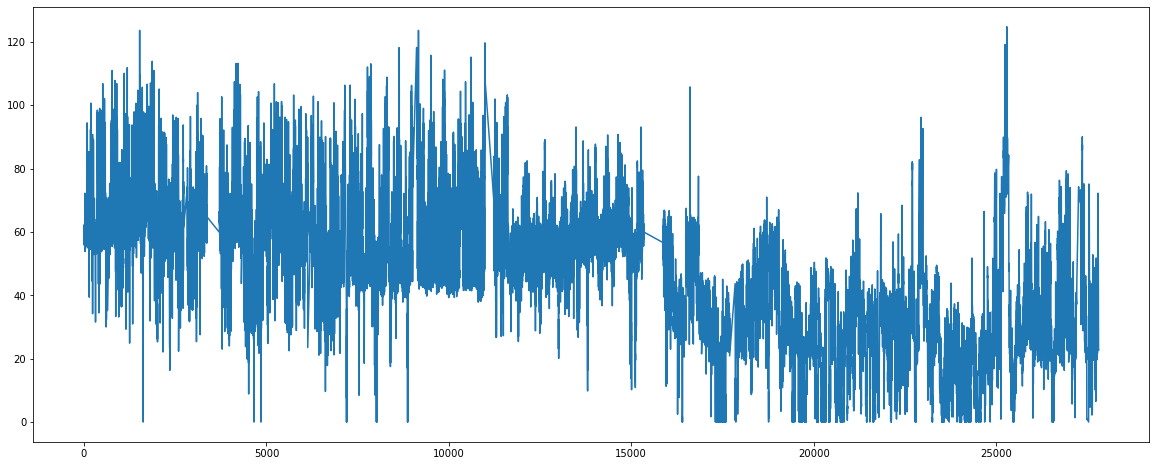

In [80]:
train_y.plot(figsize = (20,8))

<AxesSubplot:>

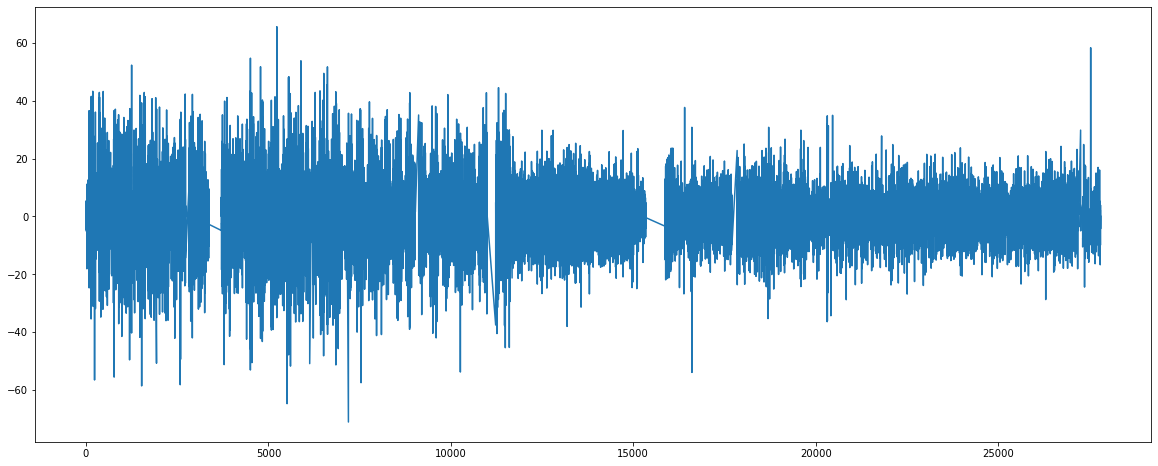

In [85]:
shifted = train_y-train_y.shift(1)
shifted.dropna().plot(figsize = (20,8))